In [1]:
from xml.dom import minidom
import os
import pandas as pd
# parse an xml file by name
metadatafilename = '/Users/keikhosravia2/Desktop/AssayPlate_PerkinElmer_CellCarrier-384/MeasurementData.mlf'
mydoc = minidom.parse(metadatafilename)
PATH_TO_FILES = os.path.split(metadatafilename)[0]
items = mydoc.getElementsByTagName('bts:MeasurementRecord')

df_cols = ["ImageName", "Column", "Row", "TimePoint", "FieldIndex", "ZSlice", "Channel"]
rows = []

for i in range(items.length):

    rows.append({
                 "ImageName": os.path.join(PATH_TO_FILES, items[i].firstChild.data), 
                 "Column": items[i].attributes['bts:Column'].value, 
                 "Row": items[i].attributes['bts:Row'].value, 
                 "TimePoint": items[i].attributes['bts:TimePoint'].value, 
                 "FieldIndex": items[i].attributes['bts:FieldIndex'].value, 
                 "ZSlice": items[i].attributes['bts:ZIndex'].value, 
                 "Channel":items[i].attributes['bts:Ch'].value
                })
    
out_df = pd.DataFrame(rows, columns = df_cols)

(-0.5, 2561.5, 2161.5, -0.5)

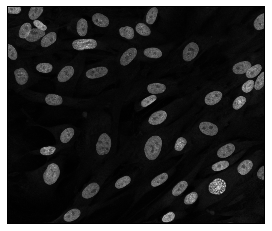

In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from matplotlib import pyplot as plt

df = out_df
select_color = df.loc[(df['Column'] == '9') & (df['Row'] == '14') & (df['TimePoint'] == '1') & 
                         (df['FieldIndex'] == '9')& (df['Channel']=='1' )]
from PIL import Image
z_imglist=[]
for index, row in select_color.iterrows():
    im = Image.open(row['ImageName'])
    z_imglist.append( np.asarray(im))
z_stack = np.stack(z_imglist, axis=2)
max_project = z_stack.max(axis=2)
#ch3_img = mpimg.imread(select_color.loc[select_color['Channel']=='1']['ImageName'].iloc[0])
height, width = np.shape(max_project)
img_uint8 = cv2.normalize(max_project, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img_uint8= cv2.copyMakeBorder(img_uint8,5,5,5,5,cv2.BORDER_CONSTANT,value=0)
plt.imshow(img_uint8, cmap='gray')
plt.axis('off')

In [16]:
a,b=[],[]
if a==[]:
    print(a,b)

[] []


uint8


(-0.5, 2561.5, 2161.5, -0.5)

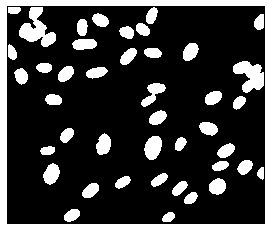

In [66]:
from scipy import ndimage

median_img_2 = cv2.medianBlur(img_uint8,31)
blur = cv2.GaussianBlur(median_img_2,(5,5),0)

ret2, thresh2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
bin_img = (1-thresh2/255).astype('bool')
filled = ndimage.binary_fill_holes(bin_img)
filled_int= (filled*255).astype('uint8')
print(filled_int.dtype)
cv2.imwrite('filled.jpg',filled_int)
plt.imshow(filled_int, cmap='gray')
plt.axis('off')

In [ ]:
from scipy.ndimage import label
from skimage.color import label2rgb
img_rgb  = cv2.cvtColor(img_uint8,cv2.COLOR_GRAY2RGB)
dt = cv2.distanceTransform(filled.astype(np.uint8), 2, 3)
dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
_, dt = cv2.threshold(dt, 100, 255, cv2.THRESH_BINARY)
lbl, ncc = label(dt)
lbl = lbl * (255 / (ncc + 1))
lbl = lbl.astype(np.int32)
#cv2.watershed(img_rgb, lbl)
lbl[lbl == -1] = 0
lbl = lbl.astype(np.uint8)
cv2.imwrite('lbl.jpg',lbl)
plt.imshow(lbl, cmap='gray')
plt.axis('off')

(2162, 2562, 3)


(-0.5, 2561.5, 2161.5, -0.5)

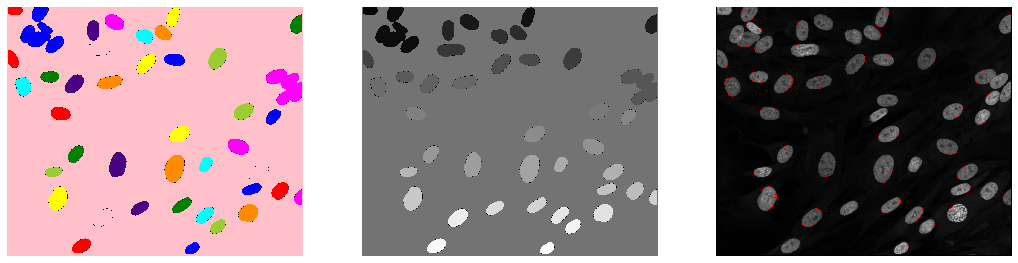

In [70]:
from scipy.ndimage import label
from skimage.color import label2rgb
img_rgb  = cv2.cvtColor(img_uint8,cv2.COLOR_GRAY2RGB)
boundary = img_rgb
boundary = boundary - img_rgb

dt = cv2.distanceTransform(filled.astype(np.uint8), 2, 3)

dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
_, dt = cv2.threshold(dt, 40, 255, cv2.THRESH_BINARY)
lbl, ncc = label(dt)
lbl = lbl * (255 / (ncc + 1))
lbl = lbl.astype(np.int32)

lbl = cv2.watershed(img_rgb, lbl)
img_rgb[lbl == -1] = [255,0,0]
boundary[lbl == -1] = [255,255,255]

rgb_lbl = label2rgb(lbl)
rgb_lbl = (rgb_lbl*255).astype(np.int32)
cv2.imwrite('boundary.jpg',boundary)
#plt.imsave('boundary.jpg',boundary)
print(boundary.shape)
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(rgb_lbl, cmap = 'gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(lbl, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(img_rgb)
plt.axis('off')

In [ ]:
boundary[0,:] = 0
boundary[-1,:] = 0
boundary[:,0] = 0
boundary[:, -1] = 0
b_gray = cv2.cvtColor(boundary,cv2.COLOR_BGR2GRAY)
diff = filled_int-b_gray

kernel = np.ones((11,11), np.uint8)
first_pass = cv2.morphologyEx(diff, cv2.MORPH_OPEN, kernel)
#first_pass = filled_int-openned
cv2.imwrite('boundary.jpg',first_pass)

(2152, 2552)


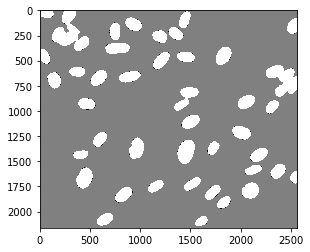

In [71]:
lbl1=lbl
lbl1[lbl1!=-1]=0
lbl1[lbl1==-1]=255
lbl1.astype(np.uint8)
#kernel = np.ones((11,11), np.uint8)
#dilated_filled = cv2.dilate(filled_int,kernel,iterations = 1)

#filled_int= (dilated_filled*255).astype('uint8')
#lbl1[0,:] = dilated_filled[0,:]
#lbl1[-1,:] = dilated_filled[-1,:]
#lbl1[:,0] = dilated_filled[:,0]
#lbl1[:, -1] = dilated_filled[:, -1]
lbl2 = lbl1[5:lbl1.shape[0]-5,5:lbl1.shape[1]-5]
first_pass = filled_int-lbl1
cv2.imwrite('label_mod.jpg',first_pass)
#bound1 = 1-lbl
#lbl1.astype(np.uint8)
plt.imshow(first_pass,cmap='gray')
print(lbl2.shape)

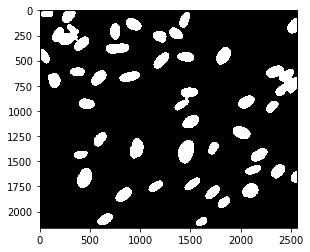

In [72]:
kernel = np.ones((7,7),np.uint8)
aa = first_pass.astype('uint8')
erosion = cv2.erode(aa,kernel,iterations = 1)

kernel = np.ones((11,11), np.uint8)
opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
blur = cv2.GaussianBlur(opening,(11,11),50)
ret2, thresh2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

cv2.imwrite('opened.jpg',255-thresh2)
#plt.imsave('lbl_binary.jpg', lbl2, cmap='gray')
plt.imshow(255-thresh2, cmap='gray')

(-0.5, 2561.5, 2161.5, -0.5)

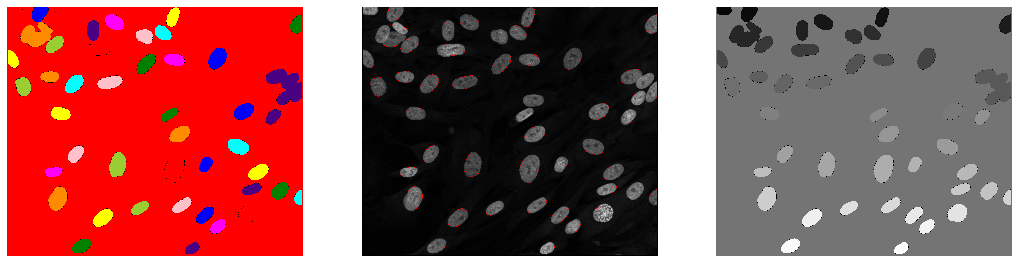

In [73]:
dt = cv2.distanceTransform(255-thresh2, 2, 3)

dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
_, dt = cv2.threshold(dt, 100, 255, cv2.THRESH_BINARY)
lbl, ncc = label(dt)
lbl = lbl * (255 / (ncc + 1))
lbl = lbl.astype(np.int32)
lll = lbl
cv2.watershed(img_rgb, lbl)

rgb_img = label2rgb(lbl)

cv2.imwrite('label_gray.jpg',lbl)
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(rgb_img, cmap = 'gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(img_rgb, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(lbl, cmap='gray')
plt.axis('off')

In [18]:
def neuceli_segmenter(input_img, pixpermic = None):
    
    
    img_uint8 = cv2.copyMakeBorder(input_img,5,5,5,5,cv2.BORDER_CONSTANT,value=0)
    ## First blurring round
    median_img = cv2.medianBlur(img_uint8,31)
    gaussian_blurred = cv2.GaussianBlur(median_img,(5,5),0)
    ## Threhsolding and Binarizing
    ret, thresh = cv2.threshold(gaussian_blurred,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    bin_img = (1-thresh/255).astype('bool')
    ## Binary image filling
    filled = ndimage.binary_fill_holes(bin_img)
    filled_int= (filled*255).astype('uint8')
    ## Gray2RGB to feed the watershed algorithm
    img_rgb  = cv2.cvtColor(img_uint8,cv2.COLOR_GRAY2RGB)
    boundary = img_rgb
    boundary = boundary - img_rgb
    ## Distance trasform and thresholing to set the watershed markers
    dt = cv2.distanceTransform(filled.astype(np.uint8), 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
    _, dt = cv2.threshold(dt, 100, 255, cv2.THRESH_BINARY)
    lbl, ncc = label(dt)
    lbl = lbl * (255 / (ncc + 1))
    lbl = lbl.astype(np.int32)
    ## First round of Watershed transform
    cv2.watershed(img_rgb, lbl)
    ## Correcting image boundaries
    boundary[lbl == -1] = [255,255,255]
    boundary[0,:] = 0
    boundary[-1,:] = 0
    boundary[:,0] = 0
    boundary[:, -1] = 0
    b_gray = cv2.cvtColor(boundary,cv2.COLOR_BGR2GRAY)
    diff = filled_int-b_gray

    kernel = np.ones((11,11), np.uint8)
    first_pass = cv2.morphologyEx(diff, cv2.MORPH_OPEN, kernel)

    ## Second round of marker generation and watershed 
    kernel = np.ones((5,5),np.uint8)
    aa = first_pass.astype('uint8')
    erosion = cv2.erode(aa,kernel,iterations = 1)
    kernel = np.ones((11,11), np.uint8)
    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
    blur = cv2.GaussianBlur(opening,(11,11),50)
    ret2, thresh2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    dt = cv2.distanceTransform(255-thresh2, 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
    _, dt = cv2.threshold(dt, 100, 255, cv2.THRESH_BINARY)
    lbl, ncc = label(dt)
    lbl = lbl * (255 / (ncc + 1))
    lbl = lbl.astype(np.int32)
    cv2.watershed(img_rgb, lbl)
    ########
    boundary = img_rgb
    boundary = boundary - img_rgb

    boundary[lbl == -1] = [255,255,255]
    boundary_img = boundary[3:boundary.shape[0]-3,3:boundary.shape[1]-3]
    bound_gray = cv2.cvtColor(boundary_img,cv2.COLOR_BGR2GRAY)
    resized_bound = cv2.resize(bound_gray,(input_img.shape[1],input_img.shape[0]))
    
    kernel = np.ones((3,3),np.uint8)
    boundary = cv2.dilate(resized_bound,kernel,iterations = 1)
    filled1 = ndimage.binary_fill_holes(boundary)
    fin= 255*filled1-boundary
    mask = ndimage.binary_fill_holes(fin)
    mask = (255*mask).astype(np.uint8)

    return boundary, mask

In [74]:
from scipy import ndimage
from scipy.ndimage import label
import numpy as np
import cv2
from skimage.color import label2rgb
import time
t0= time.clock()


input_image=img_uint8
bound, filled_res = neuceli_segmenter(input_image)
t1 = time.clock() - t0
print("Time elapsed: ", t1) # CPU seconds elapsed (floating point)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


Time elapsed:  1.5973180000000013


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


(2152, 2552)


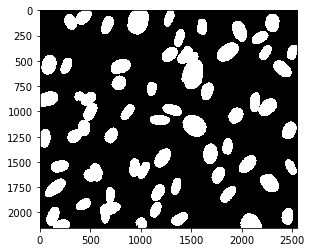

In [22]:
plt.imshow(filled_res, cmap = 'gray')
print(input_image.shape)

In [27]:
cv2.imwrite('final_boundary.jpg',rgblabel)

True

In [52]:
labeled_array, num_features = label(filled_res)
rgblabel = label2rgb(labeled_array,alpha=0.1, bg_label = 0)
rgblabel = cv2.normalize(rgblabel, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
ch1_rgb = np.stack((input_image,)*3, axis=-1)
All_Channels = cv2.addWeighted(rgblabel,0.2, ch1_rgb, 1, 0)

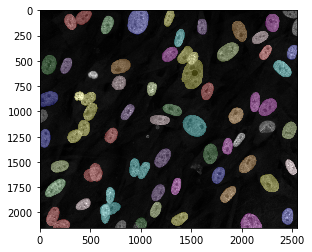

In [53]:
plt.imshow(All_Channels)

In [42]:
ch1_rgb = np.stack((input_image,)*3, axis=-1)

In [43]:
print(ch1_rgb.shape)

(2152, 2552, 3)


In [75]:
import imagej

ModuleNotFoundError: No module named 'imagej'